<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 8 - Transformers 
**Nome:**

**Numero Usp:**













______________

# Classificação de Texto com Transformer

O objetivo deste exercício é usar o tensorflow para implementar um único bloco encoder da arquitetura Transformer, com diversas cabeças, e usar o seu resultado para classificar um texto.  Os proncipais blocos são dados, mas você derá implementar os seguintes passos:
  1. Extrair os dados de treinamento e teste do córpus
  2. Construir o embedding e a camada de posicionamento do transformer
  3. Conectar a entrada ao blco transformer e a sua saída a uma rede feed-forward.  Compilar e testar.

## Setup


In [1]:
# https://keras.io/examples/nlp/text_classification_with_transformer/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.2.0-rc3'

## Implementa Auto-Atenção Multi-cabeça como uma camada Keras

Processamento da entrada:

  1. Para cada palavra da entrada _X_, insira num espaço de dimensão _d_;
  2. Partilha em _H_ cabeças.  Em cada cabeça multiplica _X_ com as matrizes de pesos $W_Q, W_K, W_V$;
  
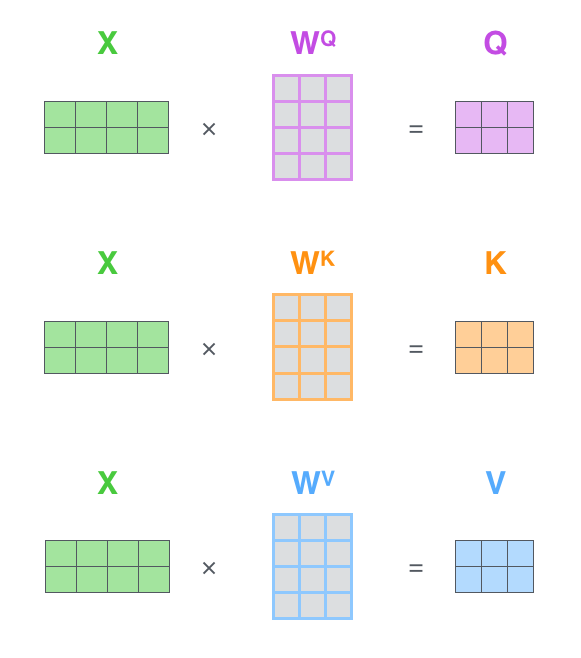

  3. Processamento de uma cabeça, calcula a atenção usando _Q,K,V_ e obtém uma matriz de saída para cada cabeça;


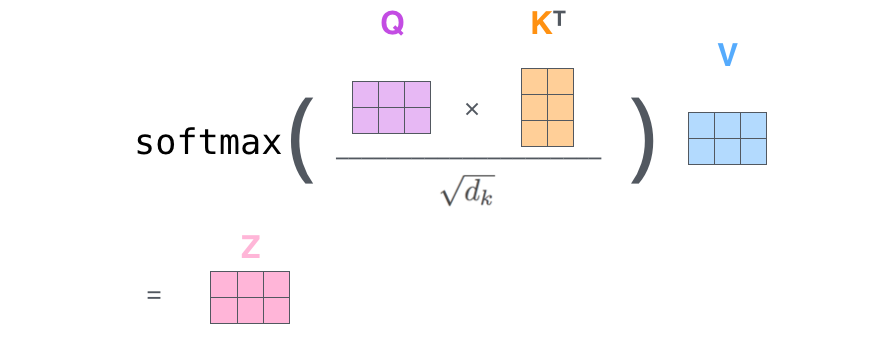

  4. Processamento multi-cabeça, concatenando as saídasem uma única matriz de saída;
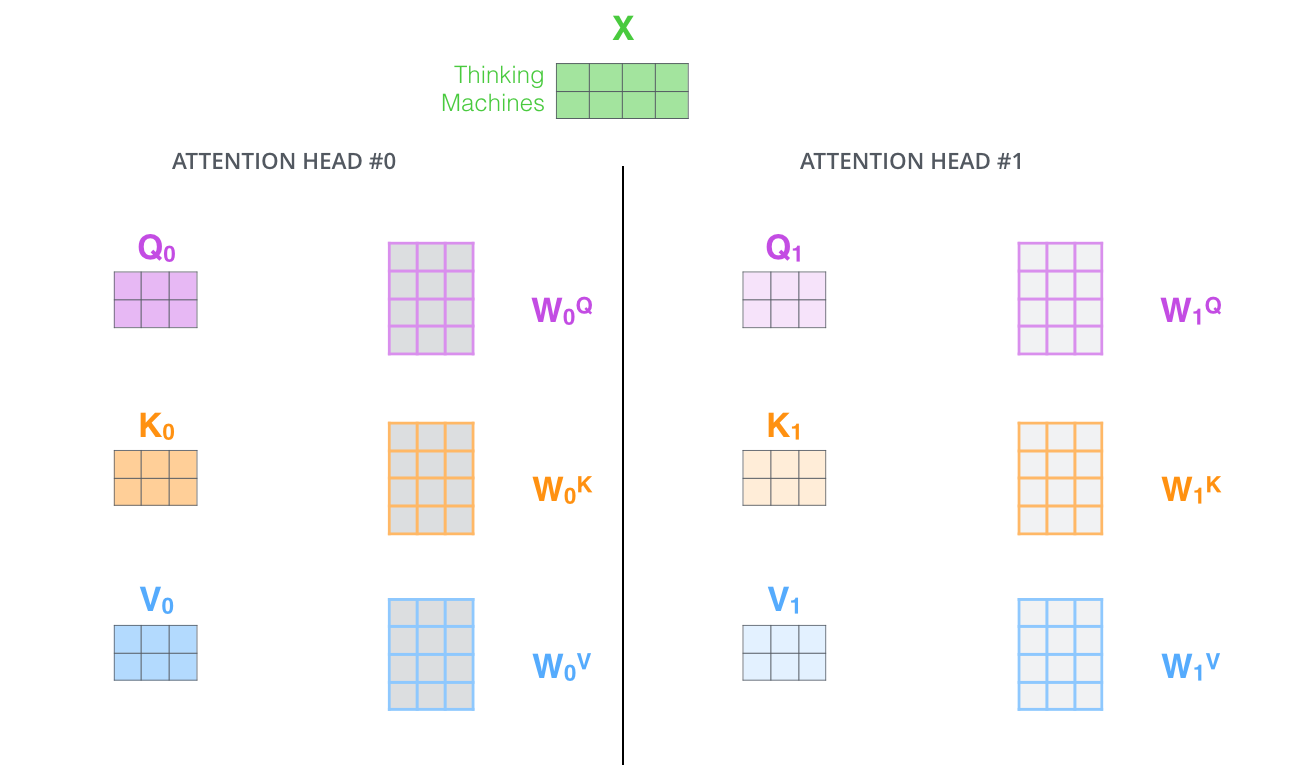



  5. Multiplica a matriz concatenada por uma matriz de pesos de saída $W^O$.

In [37]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads ):
        super(MultiHeadSelfAttention, self).__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"dimensão do embedding = {embed_dim} deve ser "  +
                "divisível pelo n. de cabeças = {num_heads}"
            )
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        # divide o embedding_dim em n_cabeças de projection_dim (batch_size e seq_len são mantidos)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        # reordena o n_cabeças com a seq_len
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)      # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output



## Implementa um bloco Transformer como uma camada


In [38]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), 
             layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



## Implementa a camada de _embedding_ e posicionamento

## <font color='blue'>Questão 1 </font>

Aqui começa a nossa implementação.  A ideia é fazer o seguinte:

  - pegue um string $s$ e substitua cada token pelo seu _embedding_ $x_e$. Vamos novamente utilizar os vetores de palavras de 50 dimensões para lingua portuguesa fornecidos pelo NILC, como na Lista 04. Para evitar problemas de mémoria você deve utilizar apenas as 200 mil palavras mais comum. Nós ja fornecemos um script que realiza esse pré-processamento por você, basta baixar o arquivo cbow_s50.zip do site do NILC, extrai-lo na pasta deste notebook e rodar a célula seguinte. 
  - vamos calcular o posicionamento (para 50 posições) de acordo com o método **Transformer**.  Existem algumas formas de fazer isso
      * Criar uma camada específica para codificar o posicionamento.  Esta camada recebe na entrada o número da posição  e retorna um vetor de tamanho embedding_dim (50 para nós), e deve ser treinada junto co o resto.
      * Usar o método de posicionamento dos Transformes. **É isso que vocês irão fazer !!!** a forma de computar esses valores é:
      
      $$PE[pos, i] = sin \left(\frac{pos}{10000^{i/d}}\right), ~~~~~i \textrm{ é par}$$
      
      $$PE[pos, i] = cos \left(\frac{pos}{10000^{(i-1)/d}} \right),   ~~~~i \textrm{ é ímpar}$$
      
onde $pos$ é a posição, $i$ é a dimensãoe $d$ é a dimensão do embedding (50, no nosso caso).  Sinta-se a vontade para alterar esta fórmula!

  - **Some** o embedding com o posicionamento

In [3]:
# !pip install gensim
from gensim.models import KeyedVectors
model_w2v = KeyedVectors.load_word2vec_format("/home/wesley/workspaces/usp/data/nilc/word2vec_200k.txt")

In [206]:
# model_w2v.get_vector('cadeira')
# model_w2v.get_vector('cadeirax')
#
# EMBED = model_w2v.get_keras_embedding()
# EMBED = model_w2v.get_keras_embedding()


# So I've found the solution. The Tokenized word index can be found in 
# word2vec_model.wv.vocab[word].index and the converse can be obtained by 
# word2vec_model.wv.index2word[word_index]. 
# get_keras_embedding() takes the former as input.

# model_w2v.vocab
# model_w2v.vocab['</s>'].index
# model_w2v.index2word[120000-1]
# model_w2v.index2word[0]
# model_w2v.word_vec('')
# model_w2v.similar_by_word('casa')


[('residãªncia', 0.8715465664863586),
 ('mansã£o', 0.8656501770019531),
 ('cabana', 0.8563933372497559),
 ('farmã¡cia', 0.8528582453727722),
 ('estalagem', 0.8522965908050537),
 ('vizinhanã§a', 0.8508816361427307),
 ('mansão', 0.8453798890113831),
 ('masmorra', 0.8431963920593262),
 ('cela', 0.8426004648208618),
 ('suã\xadte', 0.8421254754066467)]

In [7]:
EMBED = model_w2v.get_keras_embedding()

def print_sentenca(text):
    from pprint import pprint

    sentenca = text.split()

    indices_da_sentenca = [ model_w2v.vocab[palavra].index for palavra in sentenca]

    print( "Indice da sentenca..:", indices_da_sentenca  )
    print( "\n Vetor da palavra obtida diretamente..:\n" )
    pprint([ model_w2v.get_vector(palavra) for palavra in sentenca ])
    
    
    result = EMBED(tf.constant(indices_da_sentenca))
    print( "\nVetor da palavra obtida pela camada EMBED..:\n")
    pprint( result.numpy() )

print_sentenca('estou')

Indice da sentenca..: [181]

 Vetor da palavra obtida diretamente..:

[array([-5.31357e-01, -3.15500e-01, -3.79542e-01, -7.06702e-01,
       -3.62458e-01,  3.72506e-01,  6.51980e-01, -8.36400e-03,
        4.08533e-01, -4.69651e-01, -5.55438e-01,  9.43000e-04,
        5.19727e-01, -9.50345e-01,  2.52659e-01,  1.32010e-02,
       -2.32400e-03, -1.98660e-02, -1.62002e-01, -1.89100e-01,
        2.50652e-01, -6.47290e-02, -2.65350e-01,  6.86904e-01,
       -2.88721e-01, -6.28890e-02,  9.19460e-02,  5.99000e-03,
       -2.83482e-01, -2.26203e-01,  2.07830e-02, -3.32030e-02,
        8.00735e-01, -1.73474e-01,  1.37897e-01,  1.70656e-01,
        1.33770e-02,  3.27222e-01,  1.23344e-01, -1.25838e-01,
       -1.18435e-01,  5.71152e-01, -4.20442e-01,  3.22070e-01,
       -7.43320e-02, -5.84100e-03,  4.59108e-01, -9.05300e-03,
       -1.94132e-01, -1.33235e-01], dtype=float32)]

Vetor da palavra obtida pela camada EMBED..:

array([[-5.31357e-01, -3.15500e-01, -3.79542e-01, -7.06702e-01,
        -3

In [41]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
#         self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.token_emb = EMBED
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.CHAMOU = 0
    def call(self, x):
        self.CHAMOU += 1
        print("Chamou..:", self.CHAMOU)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Complete o código abaixo
# class TokenAndPositionEmbedding(layers.Layer):
#     def __init__(self, maxlen, vocab_size, embed_dim):
#         super(TokenAndPositionEmbedding, self).__init__()
#         # ...
#     def call(self, x):  # o que  é x aqui?
#         # ...
#         return x + positions
# self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

## Prepare o dataset

## <font color='blue'>Questão 2 </font>

   Vamos usar o dataset da B2W, como entrada teremos o campo `review_text` e como saída (o que queremos prever) é 0 campo `recommend_to_a_friend`, com "yes" -> 1 e "no" -> 0.
   
   V deve dividir os dados com 80% treino e 20% teste.  Dê uma embaralhada aleatória nos dados para, se você quiser, fazer validação cruzada ($k$-fold).


In [214]:
# Meus codigos...
# Ler o B2W
import pandas as pd
from sklearn.model_selection import train_test_split

b2wCorpus = pd.read_csv("../Semana 03/data/b2w-10k.csv")
# b2wCorpus.head()

df = b2wCorpus[['review_text','recommend_to_a_friend']]
df = df.assign(recommend_to_a_friend_new=0)
df['recommend_to_a_friend_new'] = df.recommend_to_a_friend.map({'Yes': 1, 'No': 0})

x_train, y_test, y_train, y_test = train_test_split(df['review_text'], df['recommend_to_a_friend_new'], test_size=0.20, random_state=17)


# b2wCorpus.review_text


def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model_w2v.vocab:
             lista[indice] = model_w2v.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

def process(text, stem=False):
#     tokens = nltk.word_tokenize(text)
    tokens = text.split()
    tokens = vocaIndex(tokens)
    return tokens

# def tokenize(lang):
#   lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
#   lang_tokenizer.fit_on_texts(lang)
#   tensor = lang_tokenizer.texts_to_sequences(lang)
#   tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')

#   return tensor, lang_tokenizer

# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0, **kwargs
# )

""
# b2wCorpus['review_text_x'] = b2wCorpus.review_text.apply(lambda x: process(x))
# b2wCorpus[['review_text_x', 'review_text']]

[[None], [None], [None], [None], [], [None], [], [None], [None], [], [None], [None], [None], [None], [None]]


In [188]:
# type(x_train)
# x_train[ x_train.keys()[1] ]

vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=200000+1,
    output_mode='int',
    output_sequence_length=200,
    standardize = 'lower_and_strip_punctuation' 
)


# vectorize_layer.set_vocabulary(model_w2v.vocab.keys())
# vectorize_layer.adapt(x_train.values)
vectorize_layer.set_vocabulary(vocab=list(model_w2v.vocab.keys()))

# vectorize_layer = preprocessing.TextVectorization()
# vectorize_layer.adapt(data)
# vectorized_text = vectorize_layer(data)
# print(vectorized_text)
# vectorized_text = vectorize_layer([["data"]])
# print(vectorized_text)



SHOW_TESTS = True
if SHOW_TESTS:
    print("   0 ---> ",vectorize_layer.get_vocabulary()[0])
    print("   3 ---> ",vectorize_layer.get_vocabulary()[3])
    print("   6378 ---> ",vectorize_layer.get_vocabulary()[6378])
    print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
    print('Tamanho do Vocab.: {}'.format(len(vectorize_layer.get_vocabulary())))
    print('O Vocabulario....: {}'.format( vectorize_layer.get_vocabulary()[0:30] ))
    
    itest = 0
#     sample_train =  x_train.iloc[313]
    sample_train = x_train.values[itest]
    sample_train = "Eu até DASDASf que não gostei DASDJKKAKMDA"
#     vec_sample_train = vectorize_layer( [[ sample_train ]] )
#     vec_sample_train = vectorize_layer( sample_train )
 
    print( "sample_train" )
    print( sample_train )
    print( len(sample_train.split()) )
    print( vec_sample_train )
#     print( vec_sample_train.shape )
# x_train.values
# vectorized_text = vectorize_layer(x_train)
# print(vectorized_text)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
input_data = [[sample_train]]
model.predict(input_data)

# x_train.values[1030]

# model_w2v.vocab
# model_w2v.vocab['gostei'].index
# model_w2v.index2word[0]
# model_w2v.index2word[0]
# model_w2v.vocab.keys()
# vectorize_layer.

   0 --->  b'</s>'
   3 --->  b'.'
   6378 --->  b'contingente'
 313 --->  b'junho'
Tamanho do Vocab.: 200000
O Vocabulario....: [b'</s>', b',', b'de', b'.', b'a', b'o', b'e', b'que', b'do', b'da', b'em', b'para', b'um', b'no', b'com', b'\xc3\xa9', b'uma', b'os', b'n\xc3\xa3o', b'na', b'00', b'0000', b'por', b')', b'(', b'as', b'se', b'dos', b'foi', b'como']
sample_train
Eu até DASDASf que não gostei DASDJKKAKMDA
7
tf.Tensor(
[[  49   67    1    9   20 6378    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0

array([[  49,   67,    1,    9,   20, 6378,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [161]:
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=200000+1,
    output_mode='int',
    output_sequence_length=200,
    standardize = 'lower_and_strip_punctuation' 
)

# vectorize_layer.adapt(x_train.values)
vectorize_layer.set_vocabulary(vocab=list(model_w2v.vocab.keys()))

# layer = preprocessing.TextVectorization()
# layer.adapt(data)
# vectorized_text = layer(data)
# print(vectorized_text)

In [ ]:
# Seu código aqui
x_train = 
y_train =
, batch_size=32, epochs=2, validation_data=(x_test, y_test

In [32]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(X_train, Y_train), (X_val, Y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(X_train), "Training sequences")
print(len(X_val), "Validation sequences")
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)[0:3000]
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)[0:3000]
Y_train = Y_train[0:3000]
Y_val = Y_val[0:3000]
X_train_n = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')
print("Tamanho do VETOR DE PALAVRAS DO TEXTO:", len(X_train[0]) )
print("Tamanho do VETOR DE PALAVRAS DO TEXTO:", len(X_train_n[0]) )

print("Tamanho do VETOR DE PALAVRAS DO TEXTO:", len(X_train[1]) )
print("Tamanho do VETOR DE PALAVRAS DO TEXTO:", len(X_train_n[1]) )
# X_train[1]
X_train_n[1]
# keras.preprocessing.sequence.pad_sequences?


25000 Training sequences
25000 Validation sequences
Tamanho do VETOR DE PALAVRAS DO TEXTO: 200
Tamanho do VETOR DE PALAVRAS DO TEXTO: 200
Tamanho do VETOR DE PALAVRAS DO TEXTO: 200
Tamanho do VETOR DE PALAVRAS DO TEXTO: 200


array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     1,   194,  1153,   194,  8255,    78,   228,
           5,     6,  1463,  4369,  5012,   134,    26,     4,   715,
           8,   118,  1634,    14,   394,    20,    13,   119,   954,
         189,   102,     5,   207,   110,  3103,    21,    14,    69,
         188,     8,    30,    23,     7,     4,   249,   126,    93,
           4,   114,     9,  2300,  1523,     5,   647,     4,   116,
           9,    35,  8163,     4,   229,     9,   340,  1322,     4,
         118,     9,     4,   130,  4901,    19,     4,  1002,     5,
          89,    29,   952,    46,    37,     4,   455,     9,    45,
          43,    38,  1543,  1905,   398,     4,  1649,    26,  6853,
           5,   163,    11,  3215, 10156,     4,  1153,     9,   194,
         775,     7,  8255, 11596,   349,  2637,   148,   605, 15358,
        8003,    15,   123,   125,    68,     2,  6853,    15,   349,
         165,  4362,

## Crie um classificador usando o bloco transformer

## <font color='blue'>Questão 3 </font>

A camada do transformer produz um vetor para cada palavra da sequência de entrada.  Aqui você tem duas possibilidades e vai ter de escolher:
  - Pegar a média em todas as saídas e usar uma rede de feed forward sobre ela para classificar o texto.
  - Inserir uma mesma palavra <start> no início de todas as sentenças, com embedding comomo de qualquer outra palavra.   Usar uma rede de feed forward sobre a saída desta palavra <start>  para classificar o texto.  

In [ ]:
# embed_dim = 32  # Embedding size for each token
# num_heads = 2  # Number of attention heads
# ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# inputs = layers.Input(shape=(maxlen,)) # a, b, c, d
# embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
# x = embedding_layer(inputs)
# transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
# x = transformer_block(x)
# x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.1)(x)
# x = layers.Dense(20, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
# outputs = layers.Dense(2, activation="softmax")(x)

# model = keras.Model(inputs=inputs, outputs=outputs)

# complete 0 código abaixo
embed_dim = 50  # tamanho do Embedding de cada token
num_heads = 5   # N. de cabeças de atenção
ff_dim = 32     # tamanho da camada oculta nas redes feed forward dentro do transformer

inputs = layers.Input(shape = ... )
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

# ...
outputs = #...

model = keras.Model(inputs=inputs, outputs=outputs)


Chamou..: 1


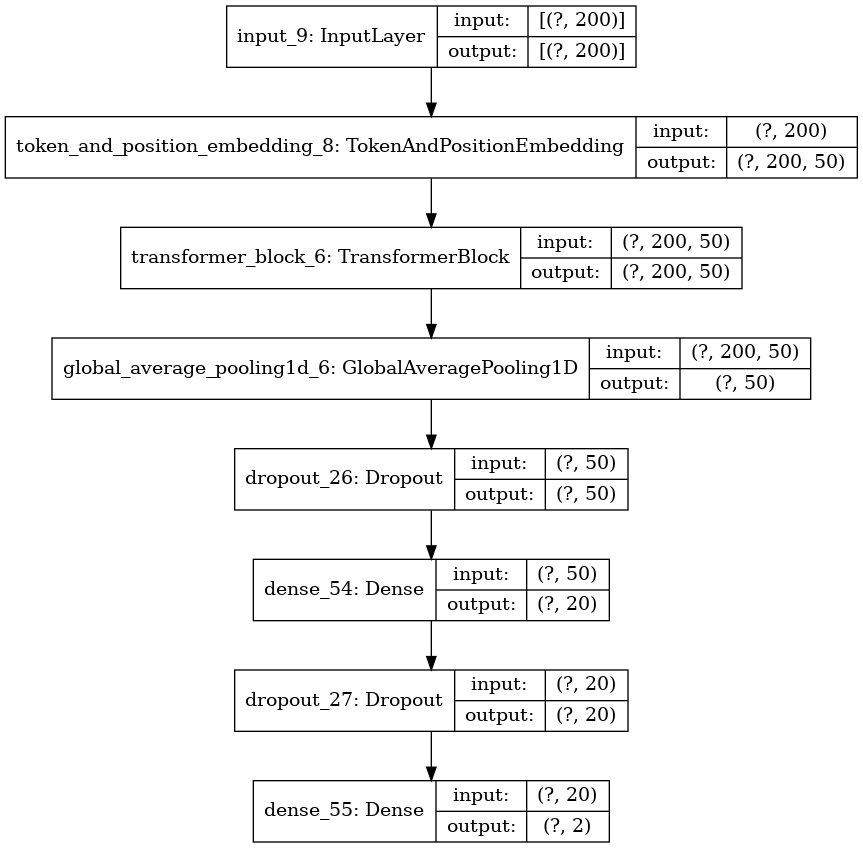

In [42]:

embed_dim = 50 # 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

keras.utils.plot_model(model, "model_text_classificarion_with_transformer.png", show_shapes=True)

## Treine e Teste

(Pode mudar, se quiser)

In [43]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
# history = model.fit(
#     x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test)
# )


history = model.fit(
    X_train, Y_train, batch_size=32, epochs=5, validation_data=(X_val, Y_val)
)


Epoch 1/5
Chamou..: 2
Chamou..: 3
94/94 [==============================] - 11s 113ms/step - loss: 0.6896 - accuracy: 0.5287 - val_loss: 0.6869 - val_accuracy: 0.5283
Epoch 2/5
94/94 [==============================] - 10s 110ms/step - loss: 0.6689 - accuracy: 0.5910 - val_loss: 0.6609 - val_accuracy: 0.6017
Epoch 3/5
94/94 [==============================] - 10s 109ms/step - loss: 0.6571 - accuracy: 0.6173 - val_loss: 0.6744 - val_accuracy: 0.5867
Epoch 4/5
94/94 [==============================] - 10s 110ms/step - loss: 0.6377 - accuracy: 0.6353 - val_loss: 0.6245 - val_accuracy: 0.6483
Epoch 5/5
94/94 [==============================] - 10s 110ms/step - loss: 0.6262 - accuracy: 0.6537 - val_loss: 0.6294 - val_accuracy: 0.6497
